# NCI Data Access: Python GeoTIFF

**The following will go through how to:** <br \>
   1. Read and extract data from an example raster (.tif) file using Rasterio and GDAL. 
   2. Simple plotting of extracted data
   3. More advanced plotting using `Cartopy` and creating RGB images


## Load required modules if working on Raijin and/or the VDI (Virtual Desktop Infrastructure)
Additional modules are needed for some of the python libraries used in this example. 

```
$ module load python/2.7.5 
$ module load gdal/1.11.1-python 
$ module load python/2.7.5-matplotlib

```

**Note:** If using a python virtual environment, these modules must be loaded before activating the working environment. 

## Load required python libraries

**Note:** Rasterio is not part of any Raijin/VDI modules and has to be installed by the user. 

In [2]:
import numpy as np
import rasterio
from osgeo import gdal
import matplotlib.pyplot as plt
%matplotlib inline

In [28]:
fileFC = '/g/data2/rs0/tiles/EPSG4326_1deg_0.00025pixel/LS8_OLI/116_-034/2015/LS8_OLI_FC_116_-034_2015-03-02T02-05-26.tif'

fn = '/g/data2/rs0/tiles/EPSG4326_1deg_0.00025pixel/LS8_OLI/116_-033/2015/LS8_OLI_NBAR_116_-033_2015-03-02T02-05-26.tif'
fn = '/Users/kdruken/Downloads/LS8_OLI_NBAR_141_-028_2015-03-02T00-24-57.tif'

## Rasterio example (uses GDAL)
For more info on Rasterio: https://pypi.python.org/pypi/rasterio


In [29]:
ds = rasterio.open(fn)
ds.meta

{'affine': Affine(0.00025, 0.0, 141.0,
       0.0, -0.00025, -27.0),
 'count': 7,
 'crs': {'init': u'epsg:4326'},
 'driver': u'GTiff',
 'dtype': 'int16',
 'height': 4000,
 'nodata': -999.0,
 'transform': (141.0, 0.00025, 0.0, -27.0, 0.0, -0.00025),
 'width': 4000}

In [30]:
print "Number of bands: ", ds.count

Number of bands:  7


In [31]:
print "Height:\t ", ds.height
print "Width:\t ", ds.width
print "CRS:\t ", ds.crs

Height:	  4000
Width:	  4000
CRS:	  {'init': u'epsg:4326'}


In [32]:
print "BoundingBox: ", ds.bounds

BoundingBox:  BoundingBox(left=141.0, bottom=-28.0, right=142.0, top=-27.0)


### Extract (read) and plot a selected band

In [33]:
data = ds.read(3)

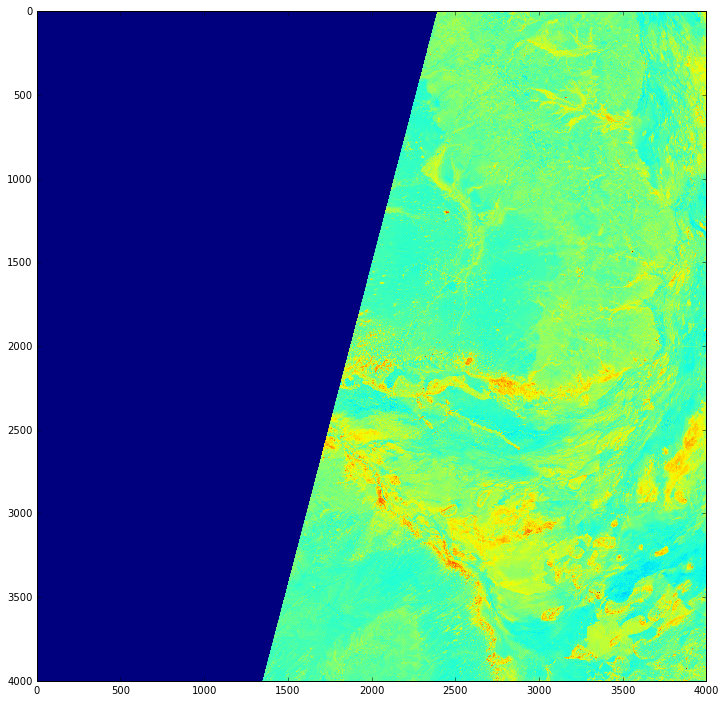

In [34]:
fig = plt.figure(figsize=(12,12))
plt.imshow(data)

### Extract small subset

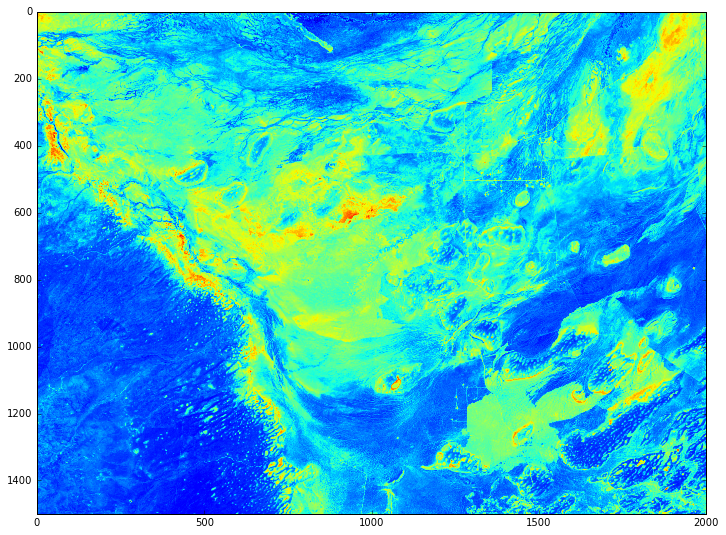

In [51]:
x1, x2 = 2500, 4000
y1, y2 = 2000, 4000

small_data = ds.read(1, window=((x1,x2), (y1,y2)))
fig = plt.figure(figsize=(12,12))
plt.imshow(small_data)

## GDAL example

#### Open file

In [37]:
ds2 = gdal.Open(fn)

In [38]:
cols = ds2.RasterXSize
rows = ds2.RasterYSize
bands = ds2.RasterCount

print "Cols: {0}, Rows: {1}, Bands: {2}".format(cols, rows, bands)

Cols: 4000, Rows: 4000, Bands: 7


#### Using the 'GetGeoTransform' we can calculate the spatial extents

In [43]:
geoTransform = ds2.GetGeoTransform()
minx = geoTransform[0]
maxy = geoTransform[3]
maxx = minx + geoTransform[1]*ds2.RasterXSize
miny = maxy + geoTransform[5]*ds2.RasterYSize
print "Spatial extent [minx,miny,maxx,maxy]: ", [minx,miny,maxx,maxy]

Spatial extent [minx,miny,maxx,maxy]:  [141.0, -28.0, 142.0, -27.0]


#### What these transform values mean:
```
transform[0] /* top left x */
transform[1] /* w-e pixel resolution */
transform[2] /* rotation, 0 if image is "north up" */
transformm[3] /* top left y */
transform[4] /* rotation, 0 if image is "north up" */
transform[5] /* n-s pixel resolution */ ```

#### Extract a band subset

In [52]:
band3 = ds2.GetRasterBand(3).ReadAsArray()[x1:x2, y1:y2]

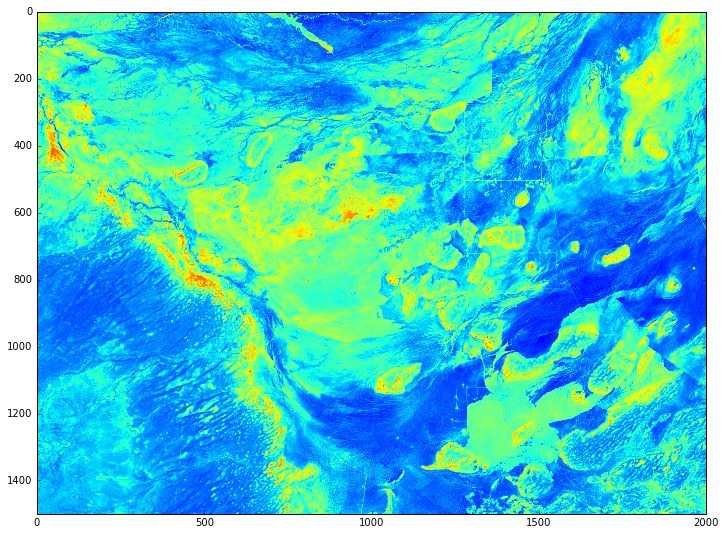

In [53]:
fig = plt.figure(figsize=(12,12))
plt.imshow(band3)

## Plotting RGB images
For more info on common band combinations: http://landsat.usgs.gov/L8_band_combos.php

In [117]:
import numpy as np

#### Read in bands
**Note**: Bands must be clipped (value of 6000 was chosen in this case) and scaled to values between (0, 255) to plot as RGB image.

In [119]:
band4 = ds2.GetRasterBand(4).ReadAsArray()[x1:x2, y1:y2]
band6 = ds2.GetRasterBand(6).ReadAsArray()[x1:x2, y1:y2]
band7 = ds2.GetRasterBand(7).ReadAsArray()[x1:x2, y1:y2]

In [120]:
b4 = band4.clip(0, 6000) / 6000. * 255
b6 = band6.clip(0, 6000) / 6000. * 255
b7 = band7.clip(0, 6000) / 6000. * 255


#### Combine the bands of interest into numpy NxNx3 dimensional array
**Note**: The data type must be converted to 'uint8' to plot as image

In [121]:
rgb = np.stack((b7, b6, b4), axis=2).astype('uint8')

print "New array shape: {0}, dtype: {1}".format(rgb.shape, rgb.dtype)

New array shape: (1500, 2000, 3), dtype: uint8


#### Plot array

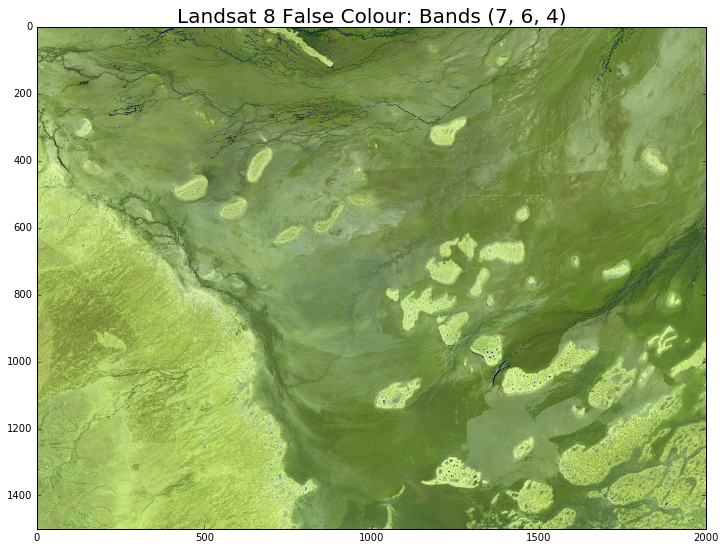

In [122]:
plt.figure(figsize=(12,12))
plt.imshow(rgb)
plt.title('Landsat 8 False Colour: Bands (7, 6, 4)', fontsize=20)

## Cartopy plotting
For more info on Cartopy: http://scitools.org.uk/cartopy/

**Note:** Cartopy is not included with the main Python modules on Raijin or the VDI and would need to be installed by the user. It also requires the `proj` module. If using within a python virtual environment, this must be loaded before activating the working environment. 
```
$ module load proj/4.8.0
```



In [224]:
import cartopy.crs as ccrs
from osgeo import osr
from cartopy.feature import NaturalEarthFeature, LAND
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

In [225]:
ausmap = gdal.Open('NE2_HR_LC_SR_W_DR.tif')

geoTransform = ausmap.GetGeoTransform()
ax1 = geoTransform[0]
ax2 = geoTransform[0] + geoTransform[1]*ausmap.RasterXSize
ay1 = geoTransform[3] + geoTransform[5]*ausmap.RasterYSize
ay2 = geoTransform[3]


aus = ausmap.ReadAsArray() #[:,6000:8500, 17000:21000]


aus = np.transpose(aus, [1,2,0])

print (ax1,ax2,ay1,ay2)

(-180.0, 180.00000000007202, -90.000000000036, 90.00000000000001)


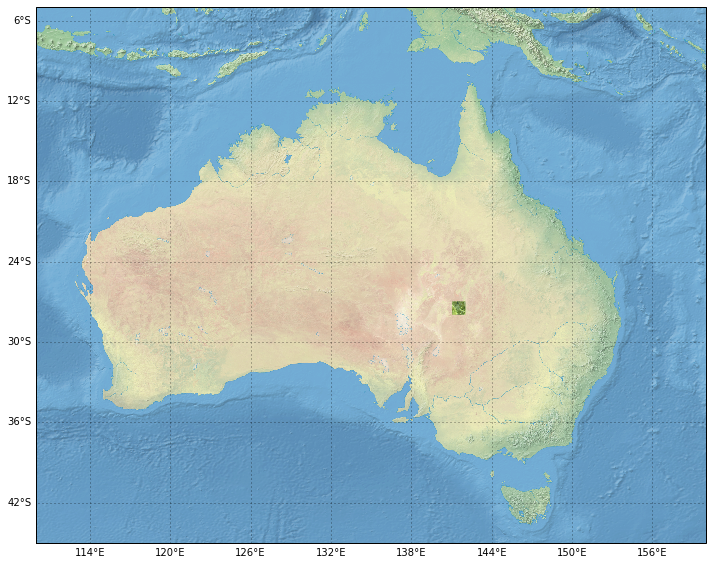

In [226]:
img = band3

img_extent = (141, 142, -28, -27)
img2_extent = (ax1,ax2,ay1,ay2)

In [ ]:
fig2 = plt.figure(figsize=(12,12))
ax = plt.axes(projection=ccrs.PlateCarree())

ax.imshow(aus, origin='upper', extent=img2_extent, transform=ccrs.PlateCarree())
ax.imshow(rgb, origin='upper', extent=img_extent, transform=ccrs.PlateCarree())

ax.set_xlim([110, 160])
ax.set_ylim([-45, -5])

gl = ax.gridlines(draw_labels=True)
gl.xlabels_top = False
gl.ylabels_right = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER

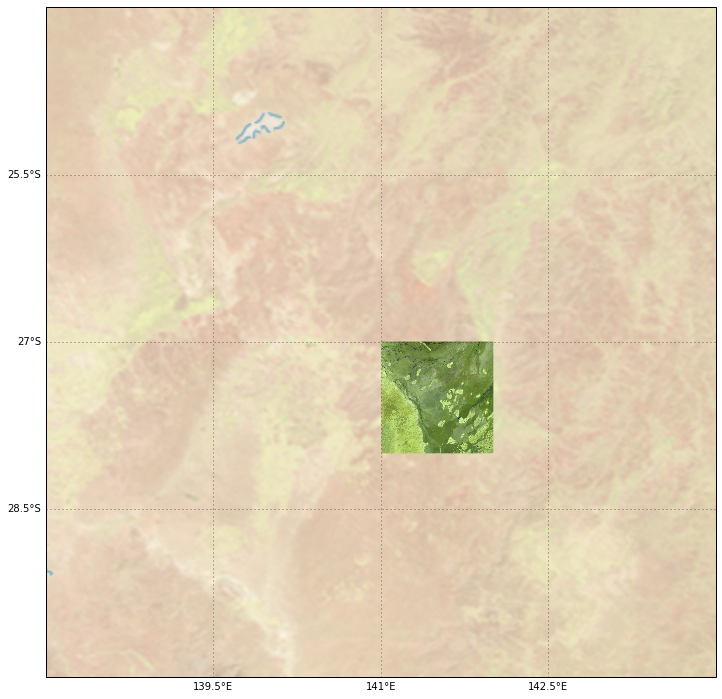

In [227]:
fig2 = plt.figure(figsize=(12,12))
ax = plt.axes(projection=ccrs.PlateCarree())

ax.imshow(aus, origin='upper', extent=img2_extent, transform=ccrs.PlateCarree())
ax.imshow(rgb, origin='upper', extent=img_extent, transform=ccrs.PlateCarree())

ax.set_xlim([138, 144])
ax.set_ylim([-30, -24])

gl = ax.gridlines(draw_labels=True)
gl.xlabels_top = False
gl.ylabels_right = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER